# Sleeping stages 
 
 We are going to detect sleeping stages from ABP signal collected in our patients. For this, we will focus on three stages. 
 
 - Wake : the patient is awake. Bêta brain waves (short and fast) are present.
 
 
 - SWS (slow-wave sleep) : part of the NREM (non rapid eye movement) stage corresponding to deep sleep. Heart rate and breathing are at their slowest rate, delta brain waves (slow and deep) are present.
 
 
 - REM (rapid eye movement) : It occurs about 90 minutes after falling asleep, and is the primary “dreaming” stage of sleep. Brain activity increases very similarily to awakening, breathing and heart rate increases. Gamma brain waves (high frequency) are present.

In [1]:
# Allow display of images
from IPython.display import display, Image

# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import glob

import pandas as pd
import seaborn as sns

# Tools from brainsignal library
import os
import sys
path=r'C:\Users\Hamon\Documents\Stage\brainsignal'
sys.path.append(path)
import brainsignal.datageneration as dg
import brainsignal.datanalysis as da
import brainsignal.HRVanalysis as ha

# This makes the plots appear inside the notebook
%matplotlib inline


# data science
from matplotlib.patches import Ellipse

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
#import pywt

# misc
import warnings

### Load data

We load the data from the txt files

In [2]:
rep='../../data/'
patientdir='ID_3'

file=glob.glob(rep+patientdir+'/WAVE_ABP.txt', recursive=True)[0]

data=pd.read_csv(file,header=None, decimal=',', delimiter='\n')
data_array=np.array(data.values)
ABP_signal=data_array.transpose()[0]

In [3]:
fs=200
ABP_time=np.arange(len(ABP_signal))/fs

### Visualisation

Let take a look to the data. We chose arbitrarily a given time window [t1 - t2] hours.

(6950.0, 7450.0)

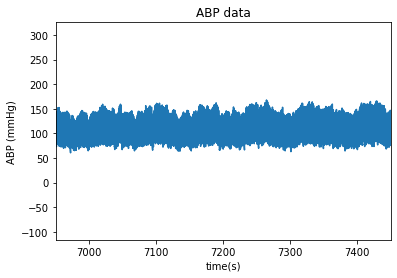

In [130]:
t1=720 #second
t2= 725 #second 
time=2 #hour
plt.figure()
plt.plot(ABP_time,ABP_signal)

plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

plt.xlim([time*60*60-250,time*60*60+250])
#plt.ylim([80,150])

# Peak detection

We would like to calculate the time interval between two cardiac pulsations which is called the RR interval in the litterature. Indeed this RR interval is used in a lot of features calculation needed to describe the signal. The RR interval can be determinated calculating the time difference between two successive peaks. 


First, let's chose a time window [start, start+duration] to study the signal in a focused interval.

Text(0, 0.5, 'Power (s²)')

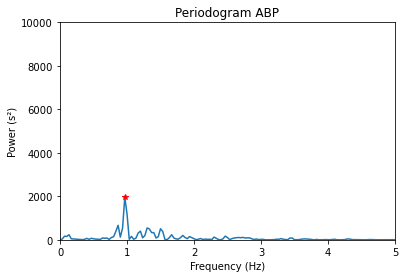

In [163]:
#Time selection 
start=time*3600 #cond departure time 
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

# periodogram 
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(ABP_signal[indices],ABP_time[indices],fmin=0.6,fmax=3)

# expected width of peaks : 
period_width=1/hr*fs

#plot 
plt.plot(frequency, power)
plt.plot(hr,power[index_hr+1],'r*')
plt.xlim([0,5])
plt.ylim([0,1e4])
plt.title('Periodogram ABP')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (s²)')

In [164]:
hr

0.9665055823818363

- Peak detection with Ricker wavelets transform

In [165]:
#peak detection 

peaks_indices_20=signal.find_peaks_cwt(vector=ABP_signal[indices],wavelet=signal.ricker,widths=[period_width/20])

#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices], ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices_20]], ABP_signal[indices[peaks_indices_20]], 'r*',label='Detected peaks')

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

plt.xlim([start,start+duration])

(7200.0, 7230.0)

- Peak detection with fourth method (see notebook 'Peak detection')

Text(0.5, 0, 'time(s)')

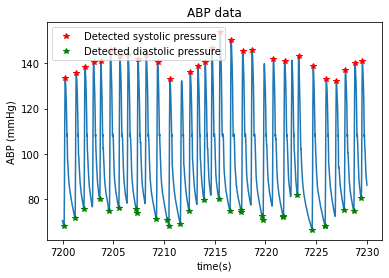

In [166]:
#peak detection 
peaks_indices=signal.argrelextrema(ABP_signal[indices], np.greater, order=int(period_width/2)) #int(len(ABP_time[indices])/fs/hr)
#order is how many points on each side to use for the comparison to consider


#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices]], ABP_signal[indices[peaks_indices]], 'r*',label='Detected systolic pressure')

# diastolic pressure plot 
pdia,index_pdia=ha.detect_min(ABP_time[indices],ABP_signal[indices],hr)
plt.plot(ABP_time[indices[index_pdia]],pdia, 'g*', label='Detected diastolic pressure')

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

#plt.ylim([50,400])

Let's try to calculate the mean of systolic pressure and diastolic pressure in this time interval. Systolic pressure is the value on top of peaks and diastolic pressure are the minimums of the signal.

In [167]:
# systolic pressure 
mean,std,pmax,pmin,median,out,idx,n=ha.psys(ABP_signal[indices],hr)
print(mean)

140.90896132896688


In [168]:
# diastolic pressure
mean,std,pmax,pmin,out,idx=ha.pdia(ABP_time[indices],ABP_signal[indices],hr)
print(mean)

73.72095331652412


Results seems coherent.

## RR-intervals

RR-intervals is the time between two peaks of ABP signal. To calculate it we take the time between two successive peaks using function 'diff()' in numpy library. We are going to plot RR-intervals founded and correct errors.

In [169]:
# RR-intervals are the differences between successive peaks
rr = np.diff(ABP_time[indices[peaks_indices]])
time_rr=ABP_time[indices[peaks_indices]][0:-1] #take all values except the last one 

# plot RR-intervals
plt.figure()
plt.title("RR-intervals")
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (s)")

plt.plot(time_rr, rr, label="RR-interval", color="#A651D8")
plt.show()

In [170]:
peaks_indices

(array([  54,  272,  445,  612,  756,  946, 1132, 1295, 1490, 1652, 1875,
        2119, 2519, 2671, 2814, 2948, 3106, 3325, 3554, 3739, 4158, 4380,
        4655, 4944, 5201, 5399, 5578, 5766, 5912], dtype=int64),)

In [171]:
#error correction 

plt.figure()
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low +0.01, 0.03,"outliers low (< mean - 2 sigma)")
plt.text(outlier_high+0.01, 0.03, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (s)")
plt.ylabel("Density")


plt.legend()
plt.show()

We reject the values outside the interval outliers low , outlier high and replace them with the median value.

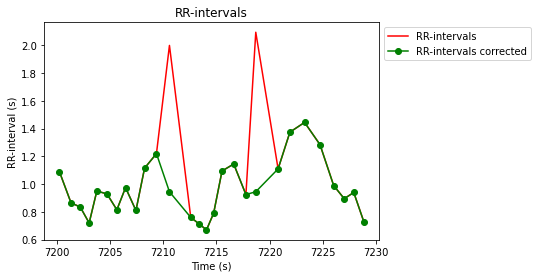

In [172]:
#visualisation of error correction 

plt.figure()

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (s)")

plt.plot(time_rr,rr, color="red", label="RR-intervals")
plt.plot(time_rr,rr_corrected,"-o", color="green",  label="RR-intervals corrected")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

We can see that RR intervals are corrected when a peak is not detected.

#### Interpolation

We interpolate rr-corrected so we can apply features calculation on it in frequency domain.

Text(0, 0.5, 'RR-interval (s)')

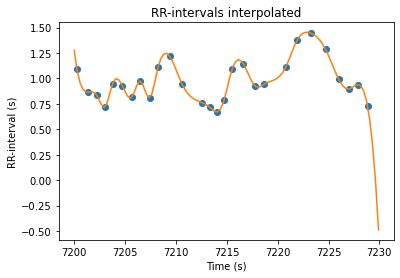

In [174]:
from scipy.interpolate import InterpolatedUnivariateSpline

# time vector creation 
spantime=dg.generate_time(duration,3.41,start)

# rr_corrected interpolation 
rr_interpolated=InterpolatedUnivariateSpline(time_rr,rr_corrected)

#plot 
plt.figure()
plt.plot(time_rr, rr_corrected, 'o')
plt.plot(spantime,rr_interpolated(spantime))
plt.title('RR-intervals interpolated')
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (s)')

# Features

To detect different sleeping stage we need to calculate some features on RR intervals all night long.

## Time-domain features 

- Mean of RR intervals

To get an idea of the value of RR intervals in the time interval.

 - Standard deviation of RR intervals
 
 Reflects the global variability of heart rate.

$$ SD=\sqrt { \frac {1}{N} \sum (\displaystyle RR_i -\overline{RR})^2} $$

Let's compare our function with the numpy function.

In [175]:
ha.SD(rr_corrected) #function HRV analysis

0.1977709811104773

In [176]:
np.std(rr_corrected) #numpy function 

0.1977709811104773

We can see that the results are the same.

- Min and max of RR intervals 

 - RMSSD (ms), the root mean square of successive differences of RR intervals for period of interest.
 
 With normal sinus rhythm reflects vagal activity, also expresses variability of high frequency mainly of parasympathetic origin, modulated by breathing.

$$ RMSSD=\sqrt { \frac {1}{N} \sum (\displaystyle RR_{i+1} -RR_i)^2} $$

Let's compare our function with a function founded in literature.

In [177]:
ha.RMSSD(rr_corrected) # function HRV analysis

0.17226433176950265

In [178]:
np.sqrt(np.mean(np.square(np.diff(rr_corrected)))) #function tutorial

0.17542540886105157

We can see that results are very close.

- NN50, the number of adjacent RR intervals differing by more than 50 ms



In [179]:
ha.NNi(rr_corrected)

21

- pNN50 (%), percent of RR intervals > 50 ms different from previous(RR) for period of interest

With normal sinus rhythm reflects vagal activity, also expresses variability of high frequency mainly of parasympathetic origin, modulated by breathing.

In [180]:
ha.pNNi(rr_corrected)

75.0

- CVSD, coefficient of variation of successive differences.

$$ CVSD=\frac{RMSSD(rr)}{\overline{RR}} $$

Reflects average short-term HRV normalized by HR

In [181]:
ha.CVSD(rr_corrected)

0.17808385783814767

- Range RR (ms), difference between the maximum and minimum RR interval.
$$ range=max(rr)-min(rr)$$

In [182]:
ha.range_nni(rr_corrected)

0.7750000000005457

- Sample entropy of the RR interval. 

It quantifies the regularity of a time series by matching a pattern of length m with any other pattern of the same length with a tolerance of r.

In [183]:
# we choose m=5 (length of template) and r=0.2 (tolerance, percent of standard deviation)
se=ha.sampen(rr_corrected)
print('sample entropy:', se)

sample entropy: 1.4157082463261839


## Frequency domain features

##### Periodogram

- Without window

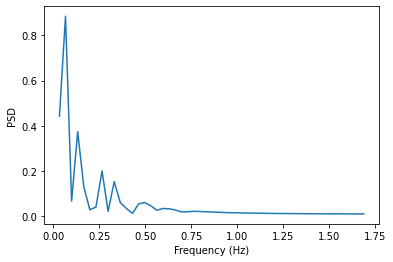

In [184]:
#periodogram
fxx,pxx =da.periodogram(rr_interpolated(spantime),spantime, window=np.ones)
da.plot_periodogram(fxx,pxx)
#plt.ylim([0,0.01])

- With window Hanning

(0.0, 0.5)

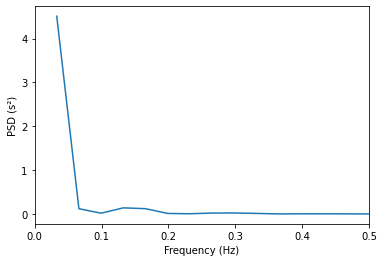

In [185]:
#periodogram
fxx,pxx =da.periodogram(rr_interpolated(spantime),spantime, window=signal.hann)
plt.plot(fxx,pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.xlim([0,0.5]) #Hz
#plt.yscale('log')
#plt.ylim([0,0.01])

We will use the periodogram from the datanalysis library with a hanning window to do our calculations.

Let's plot the periodogram on a 5 minutes window.

In [186]:
#Peak detection 
#Time selection 
start=3620 #cond departure time 
duration=300 #second

indices=da.indexseq(start, duration, ABP_time)

# periodogram ABP signal
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

# expected width of peaks : 
period_width=1/hr*fs

#peak detection 
peaks_indices=signal.argrelextrema(ABP_signal[indices], np.greater, order=int(period_width/2))

# RR-intervals are the differences between successive peaks
rr = np.diff(ABP_time[indices[peaks_indices]])
time_rr=ABP_time[indices[peaks_indices]][0:-1] #take all values except the last one

#correction 
rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

#interpolation 
# time vector creation 
spantime=dg.generate_time(duration-1,3.41,start)

# rr_corrected interpolation 
rr_interpolated=InterpolatedUnivariateSpline(time_rr,rr_corrected)

#periodogram
fxx,pxx =da.periodogram(rr_interpolated(spantime),spantime, window=signal.hann)
plt.plot(fxx,pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.xlim([0,0.5]) #Hz
plt.yscale('log')
#plt.ylim([0,0.01])
plt.title('RR intervals periodogram 5 min window t=1 hour')

Text(0.5, 1.0, 'RR intervals periodogram 5 min window t=1 hour')

### Power in frequency band

We calculate the total power in each frequency band by integrating the spectral density using function 'trapz' in numpy library. (See function 'power_frequency_band' in library HRVanalysis).

Very low frequency (VLF) : 0-0.04 Hz

Low frequency (LF) : 0.04-0.15 Hz

High freqneucy (HF) : 0.15-0.4 Hz


#### Power VLF (ms²), total power in the frequency band 0-0.04 Hz.

Reflects vagal system effects on HR.

In [187]:
#Very low frequency (0-0.04 Hz) :
vlf=da.power_in_frequency_band(fxx,pxx,0,0.04)
print('VLF (ms²):',vlf)

VLF (ms²): 81.90703350796818


#### Power LF (ms²), total power in the frequency band 0.04-0.15 Hz.

Reflect combination of sympathtic and parasympathetic nervous systems influences.

In [188]:
#Low frequency (0.04-0.15 Hz)
lf=da.power_in_frequency_band(fxx,pxx,0.04,0.15)
print('LF (ms²):',lf)

LF (ms²): 12.055359843214102


#### Power HF (ms²), total power in the frequency band 0.15-0.4 Hz.

Under normal circumstances reflects vagal activity.

In [189]:
#High frequency (0.15-0.4 Hz)
hf=da.power_in_frequency_band(fxx,pxx,0.15,0.4)
print('HF (ms²):',hf)

HF (ms²): 19.720001665161476


#### Total power of the spectrum

In [190]:
#Total power 
tf=vlf+lf+hf
print('TF (ms²):',tf)

TF (ms²): 113.68239501634376


#### Ratio LF/HF 

Purpoted to reflect sympathetic/parasympathetic balance.

In [191]:
lf/hf

0.6113265124369546

#### Peaks in frequency band 

- Peak VLF (Hz) detect the greater peak in very low frequenies.

- Peak LF (Hz) detect the greater peak in low frequencies 

- Peak HF (Hz) detect the greater peak in high frequencies

#### Fraction LF (LFn)

$$LFn=\frac{LF*100}{TP-VLF}$$

Purported to reflect sympathetic nervous system activity.

In [192]:
ha.LFn(lf, tf, vlf)

37.93933183116253

#### Fraction HF (HFn)

$$LFn=\frac{HF*100}{TP-VLF}$$

Purported to reflect parasympathetic nervous system activity.

In [193]:
ha.HFn (hf, tf, vlf)

62.06066816883746